**Import the useful package**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from cvxopt import solvers, matrix
from tqdm import tqdm 

Question 1: (10 points) For visualization purpose, generate heat maps of Reward function 1 and
Reward function 2. For the heat maps, make sure you display the coloring scale. You will have 2 plots
for this question

Generate the matrix for the reward. (Generate the reward function or reward matrix)

In [2]:
RF_1 = np.array(
    [[0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,  0,  0,  0,-10,-10,  0,  0,  0],
     [0,  0,  0,  0,  0,-10,-10,  0,  0,  0],
     [0,-10,-10,  0,  0,  0,  0,  0,  0,  0],
     [0,-10,-10,  0,  0,  0,  0,  0,  0,  0],   
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,-10,-10,  0,  0,  0,  0,  0,  0],
     [0,  0,-10,-10,  0,  0,  0,  0,  0,  1],
    ]
)
RF_2 = np.array(
    [[0,  0,  0,  0,   0,   0,   0,   0,   0,  0],
     [0,  0,  0,  0,-100,-100,-100,   0,   0,  0],
     [0,  0,  0,  0,-100,   0,-100,   0,   0,  0],
     [0,  0,  0,  0,-100,   0,-100,-100,-100,  0],
     [0,  0,  0,  0,-100,   0,   0,   0,-100,  0],
     [0,  0,  0,  0,-100,   0,   0,   0,-100,  0],
     [0,  0,  0,  0,-100,   0,   0,   0,-100,  0],
     [0,  0,  0,  0,   0,   0,-100,-100,-100,  0],
     [0,  0,  0,  0,   0,   0,-100,   0,   0,  0],
     [0,  0,  0,  0,   0,   0,   0,   0,   0,  10],
    ]
)

# translate RF_1 and RF_2 reward function from matrix into vector
RF_1 = RF_1.T.ravel()
RF_2 = RF_2.T.ravel()

Generate the function for plotting the heatmap

In [3]:
def Imshow_HeatMap(data, title = "block"):
  # Create heatmap with numbers
  fig, ax = plt.subplots()
  im = ax.imshow(data, cmap='viridis')
  # Add number annotations to each box
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      text = ax.text(j, i, round(data[i, j], 2),ha="center", va="center", color="w")
  # Add colorbar
  cbar = ax.figure.colorbar(im, ax=ax)
  # Set axis labels and title
  ax.set_title(title)
  # Show plot
  plt.show()



Generate the function for plotting the arrow

In [4]:
def Imshow_Arrow(policy_matrix, title = "block"):
  # define figure and axis by using plt to return
  figure, axis = plt.subplots()
  num = len(policy_matrix)
  # using two point here to represent the index
  min, max = 0, num
 
  for i in range(num):
    for j in range(num):
      pos = policy_matrix[i][j]
      arrow = ''
      if (pos == 0):
        arrow = u'↓'
      elif (pos == 1):
        arrow = u'→'
      elif (pos == 2):
        arrow = u'↑'
      else:
        arrow = u'←'
      axis.text(j+0.5, i+0.5, arrow, va='center', ha='center')
  axis.set_xlim(min, max)
  axis.set_ylim(min, max)
  axis.set_xticks(np.arange(max))
  axis.set_yticks(np.arange(max))
  axis.xaxis.tick_top()
  axis.grid()
  # Set axis labels and title
  axis.set_title(title)
  # Show plot
  plt.show()

Visualize the reward function

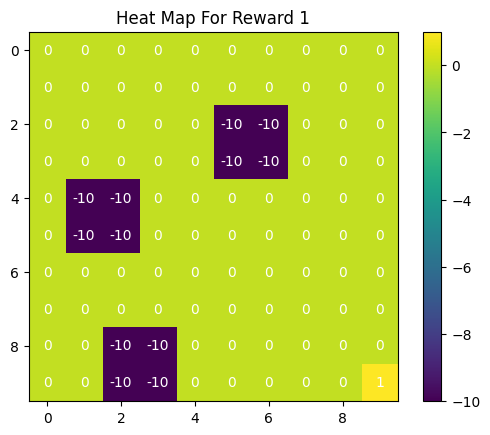

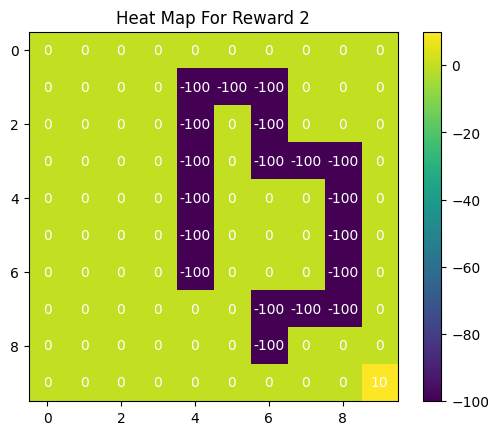

In [5]:
Imshow_HeatMap(RF_1.reshape(10,10).T, 'Heat Map For Reward 1')
Imshow_HeatMap(RF_2.reshape(10,10).T, 'Heat Map For Reward 2')

Question 2: (40 points) Create the environment of the agent using the information provided in section

Generate the 10x10 state

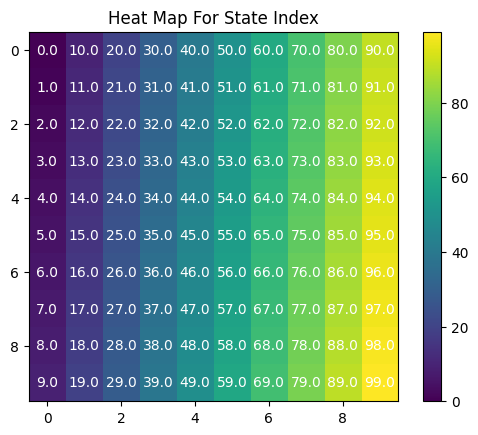

In [6]:
# initialize the state
stateIndex = np.zeros((10, 10))

# initialize the index for each state
countIndex = 0

for ii in range(0,10):
  for jj in range(0,10):
    stateIndex[jj][ii] = countIndex
    countIndex = countIndex + 1

# visualize the state
Imshow_HeatMap(stateIndex, 'Heat Map For State Index')

Generate the whole class for the Markov Decision Process (MDP)

In [7]:
# define the class for the Markov Decision Process

class MDP_gridworld(object):

  def __init__(self, num_of_states, w):
    
    # define the states
    self.num_of_states = num_of_states
    self.max_grid = int(np.sqrt(num_of_states))

    # define the w
    self.w = w

    # define the actions
    # (1,0) represent y axis +1, which is equal to move down
    # (0,1) represent x axis +1, which is equal to move right
    # (-1,0) represent y axis -1, which is equal to move up
    # (0,-1) represent x axis -1, which is equal to move left  
    self.actions = ((1,0),(0,1),(-1,0),(0,-1))
    self.num_of_actions = len(self.actions)

    # generate the transition probability matrix
    self.transition_probability = self.transition_probability_matrix()

  def index_to_grid(self, state):
    # calculate from index of a state to grid
    # as the figure 1 (index 10 -> (0,1)) (index 21 -> (1,2))
    # first return the number of row
    # second return the number of column
    return (state % self.max_grid, state // self.max_grid)

  def grid_to_index(self, grid_position):
    # calculate from index of a grid to state
    # this funciton is the inverse operation of index_to_grid
    return (grid_position[0] + grid_position[1]*self.max_grid)
  
  # calculate the next state from current state is apply one kind of movement
  def state_to_next_state(self, state, move):
    colIndex, rowIndex = self.index_to_grid(state)
    colMove, rowMove = self.actions[move]
    maxIndex = self.max_grid - 1

    # if at the edge or corner
    if (colIndex + colMove < 0) or (colIndex + colMove > maxIndex) or (rowIndex + rowMove < 0) or (rowIndex + rowMove > maxIndex):
      return self.grid_to_index([colIndex, rowIndex])
    else:
      return self.grid_to_index([colIndex + colMove, rowIndex + rowMove])

  # generate the transition probability matrix
  def transition_probability_matrix(self):

    w = self.w
    transition_probability = np.zeros([self.num_of_actions, self.num_of_states, self.num_of_states])
    
    for action in range(0,self.num_of_actions):
      for current_state in range(0,self.num_of_states):
        for move in range(0,self.num_of_actions):
          probability = w / 4
          if move == action:
            probability = probability + 1 - w
          next_state = self.state_to_next_state(current_state, move)
          transition_probability[action][current_state][next_state] = transition_probability[action][current_state][next_state] + probability
    return transition_probability
  

Create the environment

In [8]:
## Generate the parameters for the Markov Decision Process 
num_of_states = 100
w = 0.1

# Make the Markov Decision Process  
MDP_wind = MDP_gridworld(num_of_states, w)

Generate the value iteration function

In [9]:
# the value iteration function will return the optimal state, iteration number, and policy
def value_iteration_function(MDP_gridworld, Reward_function, snapshots = 0, discount_factor = 0.8, epsilon = 0.01):
  
  # initialize the needed parameter
  # the transition probability matrix
  tran_pro = MDP_gridworld.transition_probability;
  # the value matrix for all state
  value_matrix = np.zeros(MDP_gridworld.num_of_states)
  # the delta
  delta = np.inf
  # the policy matrix
  policy_matrix = np.zeros(MDP_gridworld.num_of_states)
  # the total iteration number
  iter = 0

  # estimation step
  while delta > epsilon:
    # initialize the delta for each iteration
    delta = 0
    # calculate the total iteration number
    iter = iter + 1
    # estimate the value matrix for each state
    for temp_state in range(0,MDP_gridworld.num_of_states):
      temp_value = value_matrix[temp_state]
      value_matrix[temp_state] = np.amax(np.matmul(tran_pro[:,temp_state,:],(Reward_function + discount_factor*value_matrix)))
      delta = max(delta, abs(temp_value - value_matrix[temp_state]))
    # visualize the snapshots
    if snapshots != 0:
      print("Iteration Number: ", str(iter))
      Imshow_HeatMap(value_matrix.reshape(10,10).T, " Value Matrix For Iteration Number: "+str(iter))
  
  # compute the policy for each state
  for temp_state in range(0,MDP_gridworld.num_of_states):
    policy_matrix[temp_state] = np.argmax(np.matmul(tran_pro[:,temp_state,:],(Reward_function + discount_factor*value_matrix)))

  return value_matrix, policy_matrix, iter

Apply the value iteration function to the problem

Iteration Number:  1


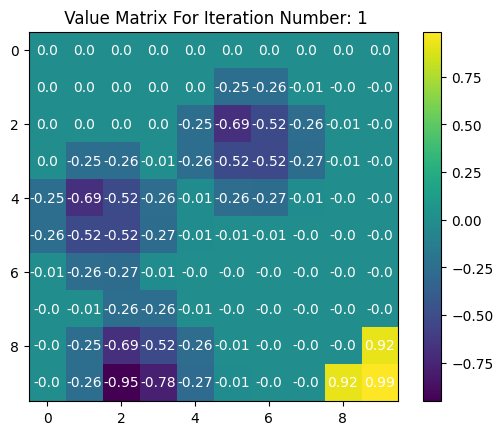

Iteration Number:  2


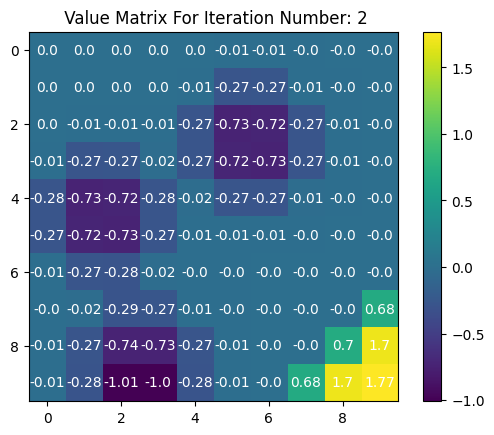

Iteration Number:  3


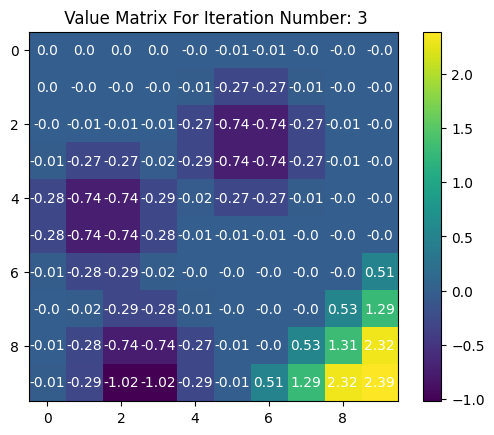

Iteration Number:  4


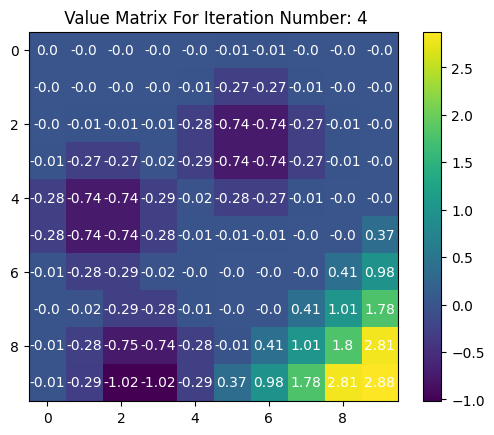

Iteration Number:  5


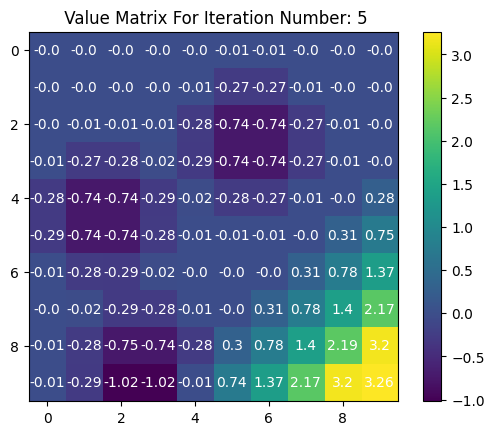

Iteration Number:  6


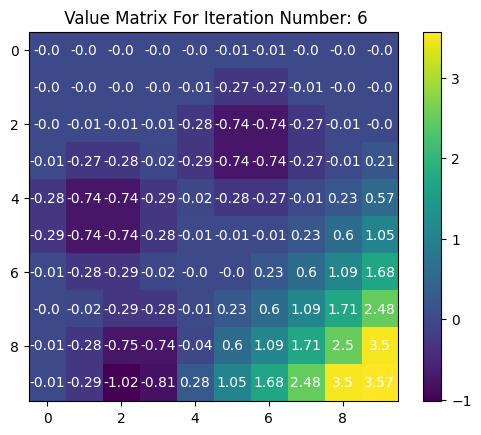

Iteration Number:  7


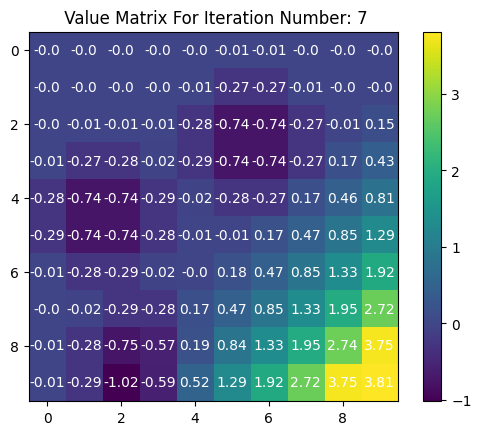

Iteration Number:  8


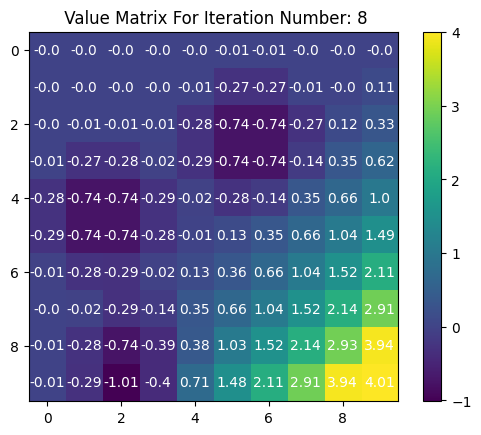

Iteration Number:  9


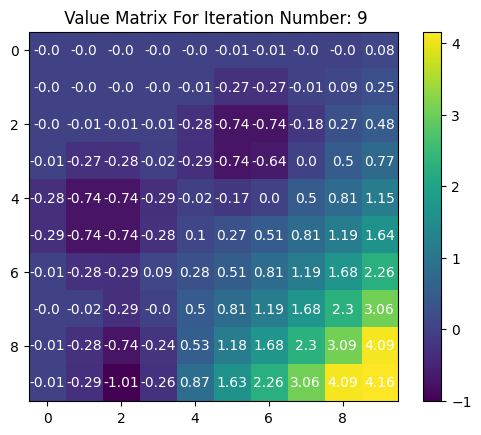

Iteration Number:  10


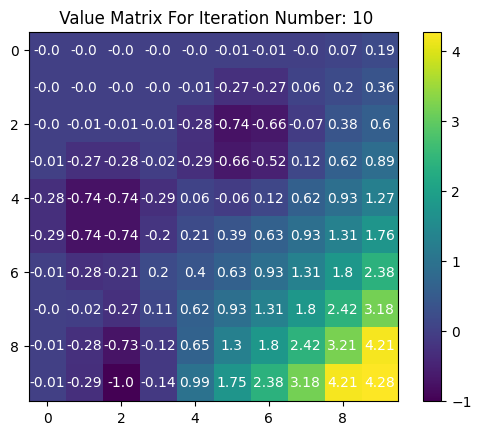

Iteration Number:  11


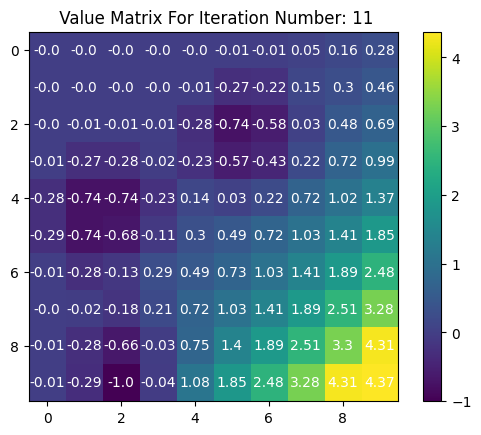

Iteration Number:  12


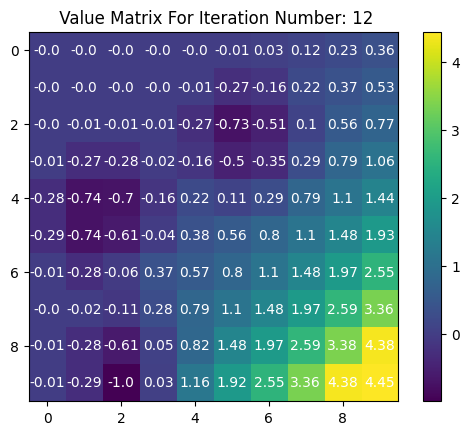

Iteration Number:  13


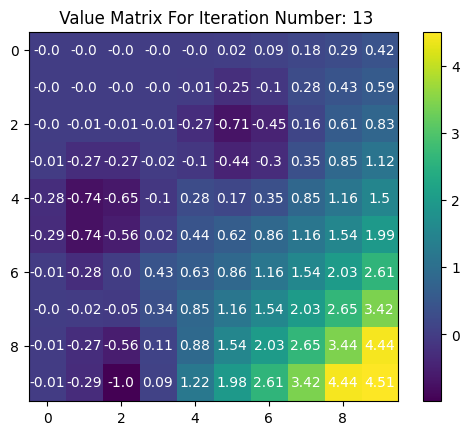

Iteration Number:  14


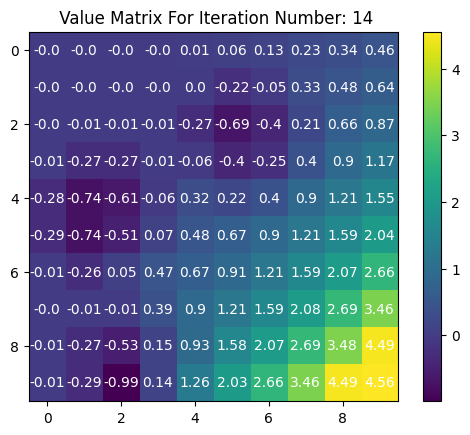

Iteration Number:  15


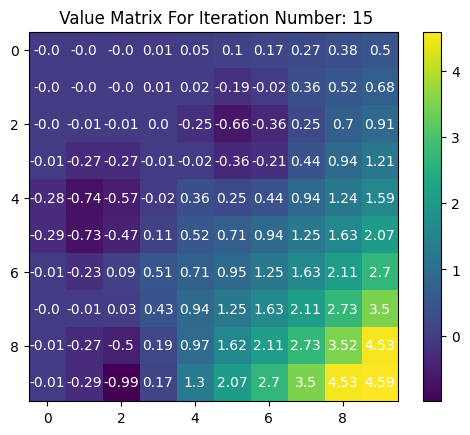

Iteration Number:  16


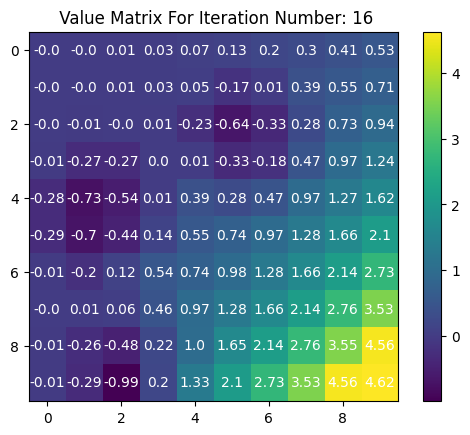

Iteration Number:  17


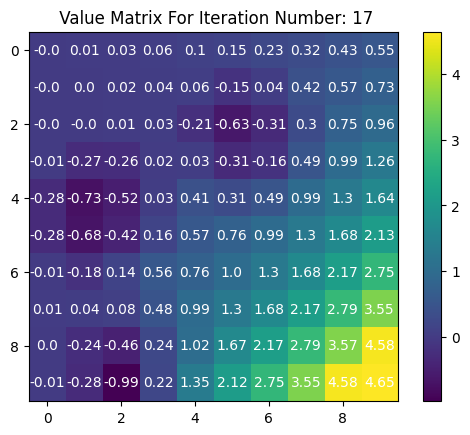

Iteration Number:  18


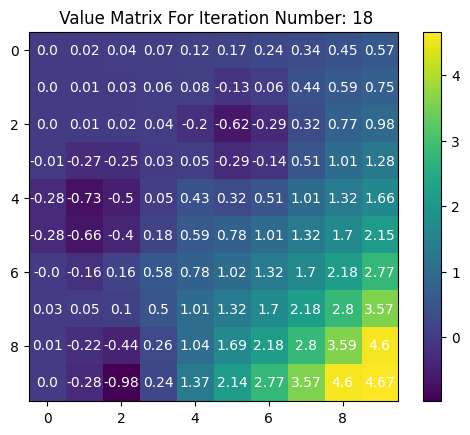

Iteration Number:  19


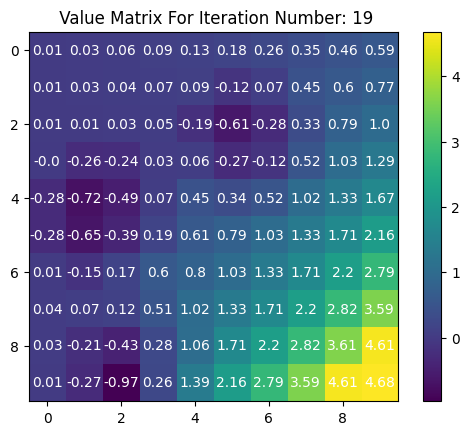

Iteration Number:  20


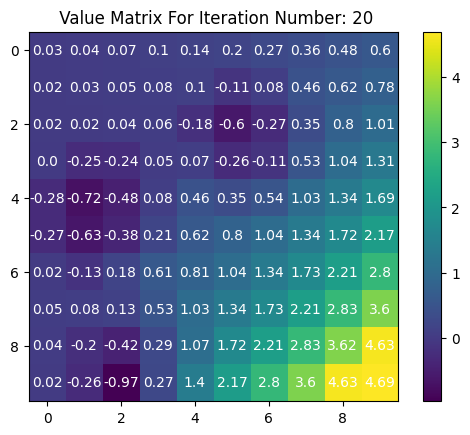

Iteration Number:  21


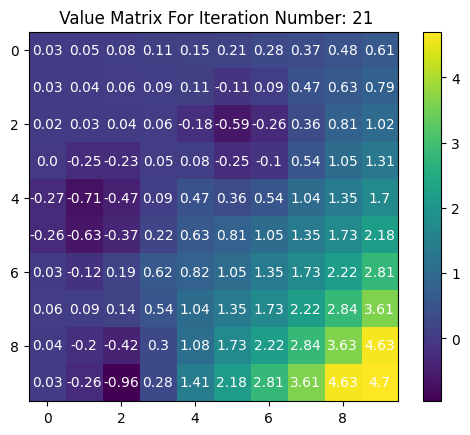

In [10]:
value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_1, 1)

Visualize the result

Total iteration number:  21


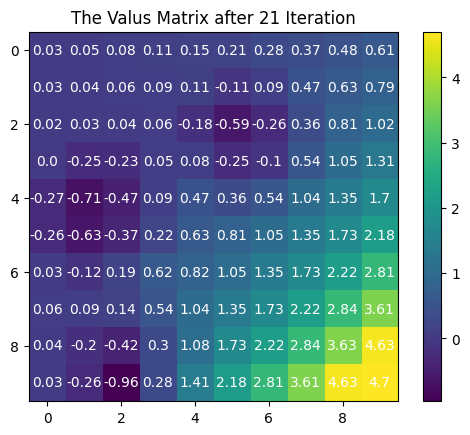

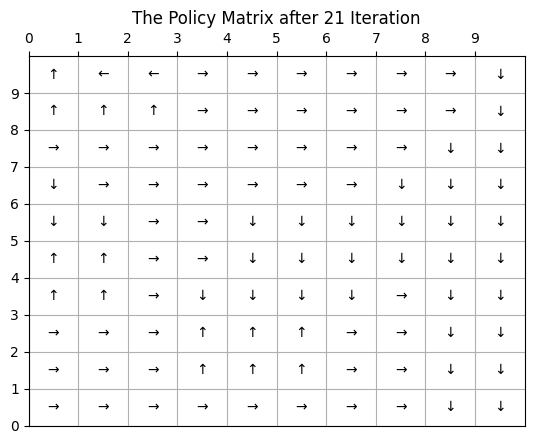

In [11]:
print('Total iteration number: ', str(total_iteration_number))
Imshow_HeatMap(value_matrix.reshape(10,10).T,'The Valus Matrix after '+str(total_iteration_number)+' Iteration')
Imshow_Arrow(policy_matrix.reshape(10,10).T,'The Policy Matrix after '+str(total_iteration_number)+' Iteration')

Question 11: (30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ.

Generate the function to obtain the Linear Programming formulation and the function of generating transition probability matrix from policy

if (pos == 0):
        arrow = u'↓'
      elif (pos == 1):
        arrow = u'→'
      elif (pos == 2):
        arrow = u'↑'
      else:
        arrow = u'←'

In [12]:
def policy_to_transition_probability_matrix(policy, MDP_gridworld):
    w = MDP_gridworld.w
    transition_probability = np.zeros([MDP_gridworld.num_of_states, MDP_gridworld.num_of_states])
    
    for current_state in range(0,MDP_gridworld.num_of_states):
      current_action = policy[current_state]
      for move in range(0,MDP_gridworld.num_of_actions):
        next_state = MDP_gridworld.state_to_next_state(current_state, move)
        probability = w / 4
        if move == current_action:
          probability = probability + 1 - w
        transition_probability[current_state][next_state] = transition_probability[current_state][next_state] + probability
    return transition_probability

Generate the LP_formulatio function to obtain D and b

In [13]:
def LP_formulation(policy, rmax, discount_factor, MDP_gridworld):
  # generate the optimal and sub-optimal transition matrix
  P_a1 = policy_to_transition_probability_matrix(np.mod(policy+0,MDP_gridworld.num_of_actions),MDP_gridworld)
  P_a2 = policy_to_transition_probability_matrix(np.mod(policy+1,MDP_gridworld.num_of_actions),MDP_gridworld)
  P_a3 = policy_to_transition_probability_matrix(np.mod(policy+2,MDP_gridworld.num_of_actions),MDP_gridworld)
  P_a4 = policy_to_transition_probability_matrix(np.mod(policy+3,MDP_gridworld.num_of_actions),MDP_gridworld)
  # short-cuts for common matrices
  N = MDP_gridworld.num_of_states
  ISS = np.identity(N)
  ZeroSS = np.zeros((N,N))
  # generate D
  D_row_1 = np.concatenate([ISS, ZeroSS, -np.dot((P_a1-P_a2), np.linalg.inv(ISS-discount_factor*P_a1))],axis=1)
  D_row_2 = np.concatenate([ISS, ZeroSS, -np.dot((P_a1-P_a3), np.linalg.inv(ISS-discount_factor*P_a1))],axis=1)
  D_row_3 = np.concatenate([ISS, ZeroSS, -np.dot((P_a1-P_a4), np.linalg.inv(ISS-discount_factor*P_a1))],axis=1)
  D_row_4 = np.concatenate([ZeroSS, ZeroSS, -np.dot((P_a1-P_a2), np.linalg.inv(ISS-discount_factor*P_a1))],axis=1)
  D_row_5 = np.concatenate([ZeroSS, ZeroSS, -np.dot((P_a1-P_a3), np.linalg.inv(ISS-discount_factor*P_a1))],axis=1)
  D_row_6 = np.concatenate([ZeroSS, ZeroSS, -np.dot((P_a1-P_a4), np.linalg.inv(ISS-discount_factor*P_a1))],axis=1)
  D_row_7 = np.concatenate([ZeroSS, -ISS, ISS],axis=1)
  D_row_8 = np.concatenate([ZeroSS, -ISS, -ISS],axis=1)
  D_row_9 = np.concatenate([ZeroSS, ZeroSS, ISS],axis=1)
  D_row_10 = np.concatenate([ZeroSS, ZeroSS, -ISS],axis=1)
  D = np.concatenate([D_row_1,D_row_2,D_row_3,D_row_4,D_row_5,D_row_6,D_row_7,D_row_8,D_row_9,D_row_10],axis=0)
    
  # generate b
  b = np.concatenate([np.zeros((8*N,)), rmax*np.ones((2*N,))])   
  return D, b 

In [14]:
# value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_1, 1)
  
import time
import cvxopt

epsilon = 0.01
discount_factor = 0.8
N = 100
value_1,policy_1,total_iteration_number = value_iteration_function(MDP_wind, RF_1, 0, discount_factor, epsilon)

number_of_lambda = 500
max_lambda = 5
accuracy_vector = np.zeros(number_of_lambda)
rmax = 1

D, b = LP_formulation(policy_1,rmax,discount_factor,MDP_wind)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,number_of_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,number_of_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    solution = solvers.lp(matrix(-c),matrix(D),matrix(b))
    option_x = np.array(solution['x'])
    RF_new = np.transpose(np.reshape(option_x[200:],(100,)))
    v,p,t = value_iteration_function(MDP_wind, RF_new, 0, discount_factor, epsilon)
    accuracy = np.sum(policy_1==p)/MDP_wind.num_of_states
    accuracy_vector[i] = accuracy

流式输出内容被截断，只能显示最后 5000 行内容。
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1538e+02  2e+03  2e+00  1e+01  1e+00
 1: -3.2553e+00 -1.9097e+02  1e+03  1e+00  7e+00  1e+00
 2: -5.8652e+00 -7.9278e+01  3e+02  5e-01  3e+00  7e-01
 3: -5.4878e+00 -5.8976e+01  2e+02  4e-01  2e+00  5e-01
 4: -8.1693e+00 -1.8242e+01  3e+01  7e-02  4e-01  1e-01
 5: -7.2512e+00 -1.1812e+01  1e+01  3e-02  2e-01  4e-02
 6: -7.0917e+00 -9.1777e+00  6e+00  1e-02  8e-02  2e-02
 7: -7.0359e+00 -7.6718e+00  2e+00  5e-03  2e-02  4e-03
 8: -7.0057e+00 -7.1978e+00  6e-01  1e-03  7e-03  1e-03
 9: -7.0013e+00 -7.0819e+00  2e-01  6e-04  3e-03  5e-04
10: -6.9969e+00 -7.0163e+00  6e-02  1e-04  7e-04  6e-05
11: -6.9965e+00 -7.0047e+00  2e-02  6e-05  3e-04  2e-05
12: -6.9961e+00 -7.0012e+00  1e-02  4e-05  2e-04  2e-05
13: -6.9958e+00 -6.9963e+00  2e-03  4e-06  2e-05  2e-06
14: -6.9957e+00 -6.9958e+00  1e-04  3e-07  1e-06  1e-07
15: -6.9957e+00 -6.9957e+00  1e-06  3e-09  1e-08  1e-09
Optimal solution found.

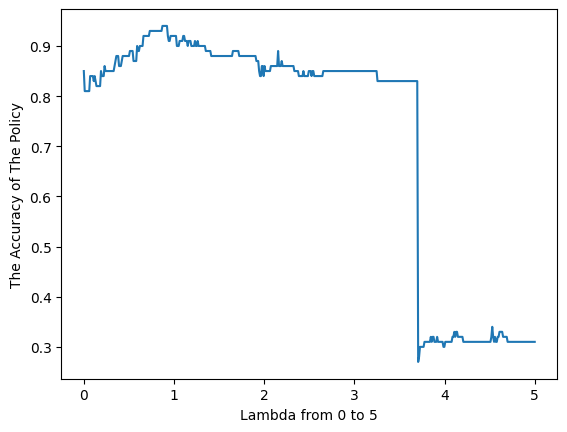

In [15]:
plt.plot(np.linspace(0,max_lambda,number_of_lambda),accuracy_vector)
plt.xlabel('Lambda from 0 to 5')
plt.ylabel('The Accuracy of The Policy')
plt.show()

Question 12: (5 points) Use the plot in question 11 to compute the value of λ for which accuracy is maximum. For future reference we will denote this value as λ(1) max. Please report λ(1) max

In [16]:
lamdas = np.linspace(0, 5, 500)
lambda_max_1 = max(lamdas[accuracy_vector == np.max(accuracy_vector)])
print('The Lamda max:', lambda_max_1)
print('The best accuracy:', max(accuracy_vector))

The Lamda max: 0.9218436873747494
The best accuracy: 0.94


Question 13: (15 points) For λ(1) max, generate heat maps of the ground truth reward and the extracted reward. 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1538e+02  2e+03  2e+00  2e+01  1e+00
 1: -9.7266e+00 -1.2431e+02  5e+02  8e-01  7e+00  1e+00
 2: -1.3312e+01 -1.0431e+02  4e+02  7e-01  6e+00  1e+00
 3: -1.2747e+01 -6.5799e+01  2e+02  4e-01  3e+00  7e-01
 4: -1.7264e+01 -2.8368e+01  3e+01  8e-02  7e-01  2e-01
 5: -1.8006e+01 -2.4600e+01  2e+01  5e-02  4e-01  8e-02
 6: -1.8612e+01 -2.1203e+01  8e+00  2e-02  2e-01  3e-02
 7: -1.8937e+01 -2.0170e+01  4e+00  9e-03  8e-02  1e-02
 8: -1.9144e+01 -1.9557e+01  1e+00  3e-03  3e-02  3e-03
 9: -1.9222e+01 -1.9347e+01  4e-01  9e-04  8e-03  6e-04
10: -1.9249e+01 -1.9294e+01  1e-01  3e-04  3e-03  2e-04
11: -1.9254e+01 -1.9278e+01  7e-02  2e-04  2e-03  1e-04
12: -1.9260e+01 -1.9265e+01  1e-02  3e-05  3e-04  2e-05
13: -1.9261e+01 -1.9262e+01  4e-03  9e-06  8e-05  4e-06
14: -1.9261e+01 -1.9262e+01  5e-04  1e-06  1e-05  5e-07
15: -1.9261e+01 -1.9261e+01  7e-05  2e-07  1e-06  7e-08
16: -1.9261e+01 -1.9261e+01  7e-06  2e-08  2e-07  

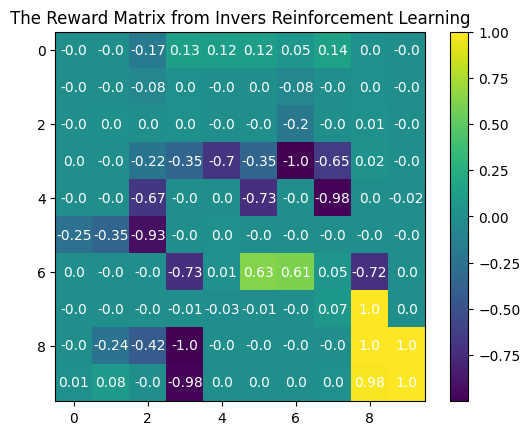

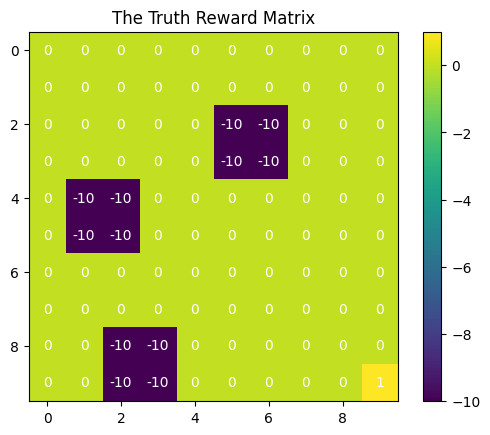

In [17]:
c = np.concatenate([np.ones((N,)), -lambda_max_1*np.ones((N,)), np.zeros((N,))])
solution = solvers.lp(matrix(-c),matrix(D),matrix(b))
option_x = np.array(solution['x'])
RF_new = np.transpose(np.reshape(option_x[200:],(100,)))

# generate value and policy from the reward function of the lambda max 
value_with_lambda_max_1,policy_with_lambda_max_1,total_iteration_number = value_iteration_function(MDP_wind, RF_new, 0, discount_factor, epsilon)
value_truth, policy_truth, total_iteration_number = value_iteration_function(MDP_wind, RF_1, 0, discount_factor, epsilon)
print("The Calculate Accuracy: %f" % (np.sum(policy_truth == policy_with_lambda_max_1)/MDP_wind.num_of_states))

Imshow_HeatMap(RF_new.reshape(10,10).T, "The Reward Matrix from Invers Reinforcement Learning")
Imshow_HeatMap(RF_1.reshape(10,10).T, "The Truth Reward Matrix")

Question 14: (10 points) Use the extracted reward function computed in question 13, to compute the optimal values of the states in the 2-D grid. 

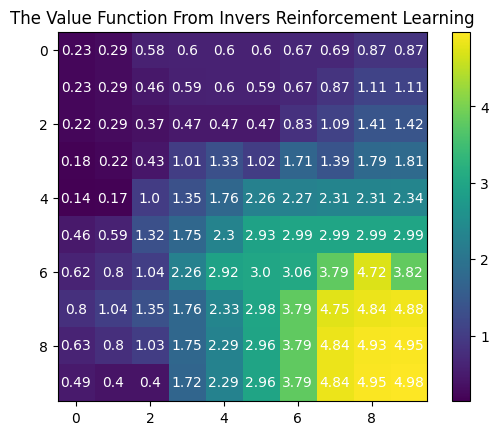

In [18]:
Imshow_HeatMap(value_with_lambda_max_1.reshape(10,10).T, "The Value Function From Invers Reinforcement Learning")

Question 15:

shown in our report.

Question 16: 

Use the extracted reward function found in question 13 to compute the optimal
policy of the agent. For computing the optimal policy of the agent you need to use the function that
you wrote in question 5. For visualization purpose, you should generate a figure similar to that of figure
1 but with the number of state replaced by the optimal action at that state. The actions should be
displayed using arrows. In this question, you should have 1 plot.

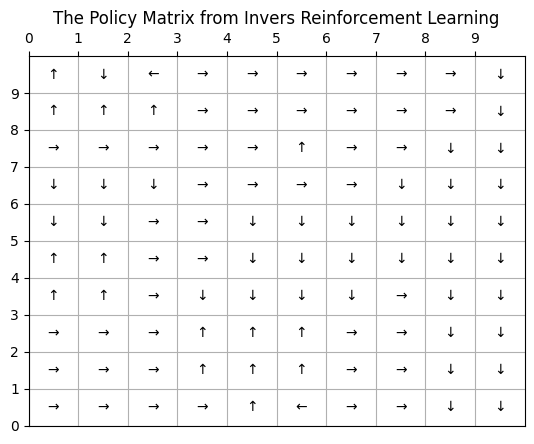

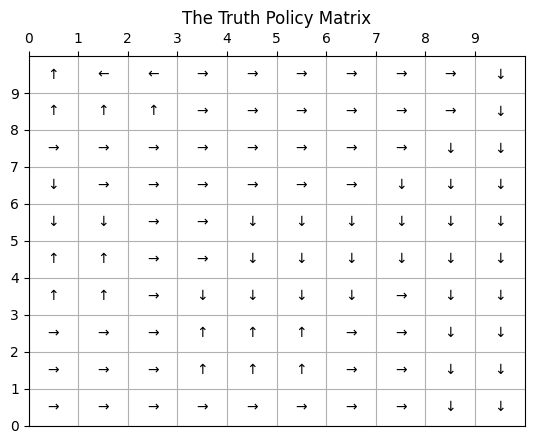

In [19]:
Imshow_Arrow(policy_with_lambda_max_1.reshape(10,10).T, "The Policy Matrix from Invers Reinforcement Learning")
Imshow_Arrow(policy_truth.reshape(10,10).T, "The Truth Policy Matrix")

Question 17

shown in our report

Question 18:

Sweep λ from 0 to 5 to get 500 evenly spaced values for λ. For each value of
λ compute OA(s) by following the process described above. For this problem, use the optimal policy of
the agent found in question 8 to fill in the OE(s) values. Then use equation 3 to compute the accuracy
of the IRL algorithm for this value of λ. You need to repeat the above process for all 500 values of λ
to get 500 data points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.

In [20]:
# value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_1, 1)
  
import time
import cvxopt

epsilon = 0.01
discount_factor = 0.8
N = 100


# here we rerun the optimal policy of the agent in question 8.
value_2,policy_2,total_iteration_number = value_iteration_function(MDP_wind, RF_2, 0, discount_factor, epsilon)

number_of_lambda = 500
max_lambda = 5
accuracy_vector = np.zeros(number_of_lambda)
rmax = 1

D, b = LP_formulation(policy_2,rmax,discount_factor,MDP_wind)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,number_of_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,number_of_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    solution = solvers.lp(matrix(-c),matrix(D),matrix(b))
    option_x = np.array(solution['x'])
    RF_new = np.transpose(np.reshape(option_x[200:],(100,)))
    v,p,t = value_iteration_function(MDP_wind, RF_new, 0, discount_factor, epsilon)
    accuracy = np.sum(policy_2==p)/MDP_wind.num_of_states
    accuracy_vector[i] = accuracy

流式输出内容被截断，只能显示最后 5000 行内容。
 3: -5.6123e+00 -3.7313e+01  1e+02  2e-01  2e+00  3e-01
 4: -8.0963e+00 -1.5975e+01  3e+01  6e-02  4e-01  8e-02
 5: -8.4399e+00 -1.1908e+01  1e+01  3e-02  2e-01  3e-02
 6: -8.6874e+00 -1.0080e+01  4e+00  1e-02  7e-02  5e-03
 7: -8.9320e+00 -9.3041e+00  1e+00  3e-03  2e-02  1e-03
 8: -8.9755e+00 -9.1594e+00  6e-01  1e-03  9e-03  6e-04
 9: -8.9775e+00 -9.1136e+00  4e-01  1e-03  6e-03  4e-04
10: -8.9924e+00 -9.0407e+00  1e-01  4e-04  2e-03  2e-04
11: -8.9972e+00 -9.0147e+00  5e-02  1e-04  8e-04  6e-05
12: -8.9994e+00 -9.0027e+00  1e-02  3e-05  2e-04  1e-05
13: -8.9996e+00 -9.0000e+00  1e-03  3e-06  2e-05  1e-06
14: -8.9997e+00 -8.9998e+00  2e-04  6e-07  4e-06  2e-07
15: -8.9997e+00 -8.9997e+00  1e-04  3e-07  2e-06  1e-07
16: -8.9997e+00 -8.9997e+00  1e-06  3e-09  2e-08  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0305e+02  2e+03  2e+00  1e+01  1e+00
 1: -4.0290e+00 -1.4746e+02  7e+02  1e+00  7e+00  1e+00

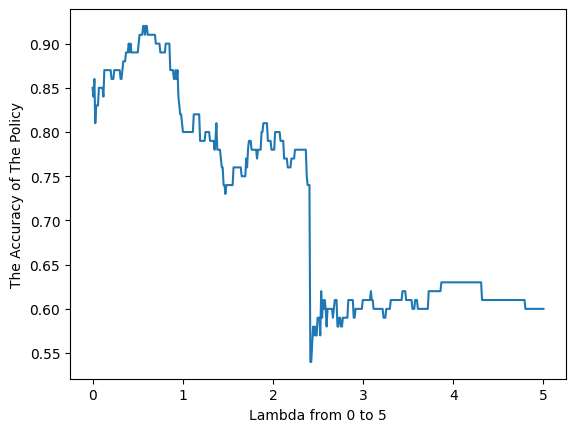

In [21]:
plt.plot(np.linspace(0,max_lambda,number_of_lambda),accuracy_vector)
plt.xlabel('Lambda from 0 to 5')
plt.ylabel('The Accuracy of The Policy')
plt.show()

Question 19: 

Use the plot in question 18 to compute the value of λ for which accuracy is
maximum.

In [22]:
lamdas = np.linspace(0, 5, 500)
lambda_max_2 = max(lamdas[accuracy_vector == np.max(accuracy_vector)])
print('The Lamda max:', lambda_max_2)
print('The best accuracy:', max(accuracy_vector))

The Lamda max: 0.6012024048096192
The best accuracy: 0.92


Question 20

For λ(2)max, generate heat maps of the ground truth reward and the extracted
reward. Please note that the ground truth reward is the Reward function 2 and the extracted reward is
computed by solving the linear program given by equation 2 with the λ parameter set to λ(2)max. In this
question, you should have 2 plots.

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0305e+02  2e+03  2e+00  2e+01  1e+00
 1: -9.0288e+00 -9.9683e+01  4e+02  7e-01  7e+00  1e+00
 2: -1.4818e+01 -7.8259e+01  3e+02  5e-01  5e+00  9e-01
 3: -1.5707e+01 -6.7143e+01  2e+02  4e-01  4e+00  6e-01
 4: -1.8176e+01 -5.5048e+01  2e+02  3e-01  3e+00  4e-01
 5: -2.4225e+01 -3.4609e+01  4e+01  8e-02  8e-01  1e-01
 6: -2.6501e+01 -3.0943e+01  2e+01  3e-02  3e-01  5e-02
 7: -2.7710e+01 -2.8967e+01  5e+00  9e-03  9e-02  8e-03
 8: -2.8081e+01 -2.8666e+01  2e+00  4e-03  4e-02  3e-03
 9: -2.8229e+01 -2.8489e+01  1e+00  2e-03  2e-02  1e-03
10: -2.8348e+01 -2.8425e+01  3e-01  6e-04  6e-03  3e-04
11: -2.8380e+01 -2.8408e+01  1e-01  2e-04  2e-03  1e-04
12: -2.8394e+01 -2.8400e+01  2e-02  4e-05  4e-04  2e-05
13: -2.8397e+01 -2.8398e+01  5e-03  1e-05  1e-04  5e-06
14: -2.8397e+01 -2.8398e+01  1e-03  2e-06  2e-05  1e-06
15: -2.8397e+01 -2.8397e+01  3e-05  6e-08  6e-07  3e-08
16: -2.8397e+01 -2.8397e+01  3e-07  6e-10  6e-09  

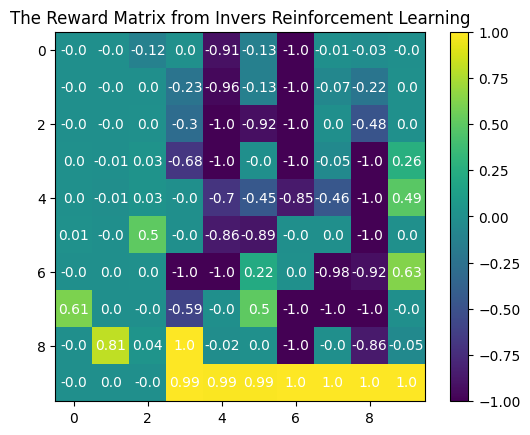

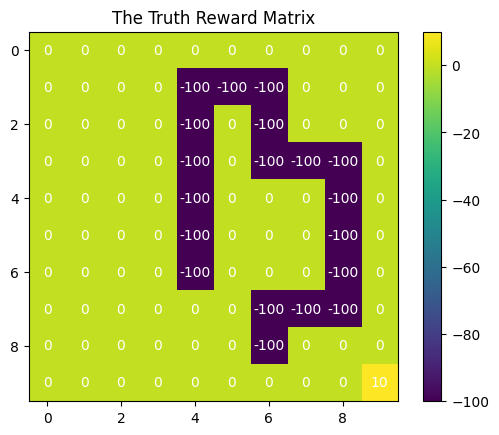

In [23]:
c = np.concatenate([np.ones((N,)), -lambda_max_2*np.ones((N,)), np.zeros((N,))])
solution = solvers.lp(matrix(-c),matrix(D),matrix(b))
option_x = np.array(solution['x'])
RF_new = np.transpose(np.reshape(option_x[200:],(100,)))

# generate value and policy from the reward function of the lambda max 
value_with_lambda_max_2,policy_with_lambda_max_2,total_iteration_number = value_iteration_function(MDP_wind, RF_new, 0, discount_factor, epsilon)
value_truth, policy_truth, total_iteration_number = value_iteration_function(MDP_wind, RF_2, 0, discount_factor, epsilon)
print("The Calculate Accuracy: %f" % (np.sum(policy_truth == policy_with_lambda_max_2)/MDP_wind.num_of_states))

Imshow_HeatMap(RF_new.reshape(10,10).T, "The Reward Matrix from Invers Reinforcement Learning")
Imshow_HeatMap(RF_2.reshape(10,10).T, "The Truth Reward Matrix")

Question 21

Use the extracted reward function computed in question 20, to compute the
optimal values of the states in the 2-D grid. For computing the optimal values you need to use the
optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat
map of the optimal state values across the 2-D grid (similar to the figure generated in question 7). In
this question, you should have 1 plot.

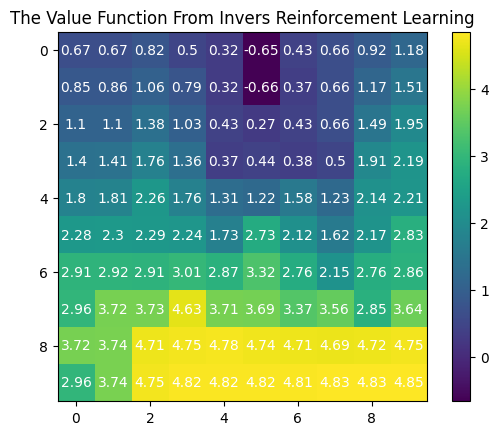

In [24]:
Imshow_HeatMap(value_with_lambda_max_2.reshape(10,10).T, "The Value Function From Invers Reinforcement Learning")

Question 22

shown in our report.

Question 23

Use the extracted reward function found in question 20 to compute the optimal
policy of the agent. For computing the optimal policy of the agent you need to use the function that
you wrote in question 9. For visualization purpose, you should generate a figure similar to that of figure
1 but with the number of state replaced by the optimal action at that state. The actions should be
displayed using arrows. In this question, you should have 1 plot.

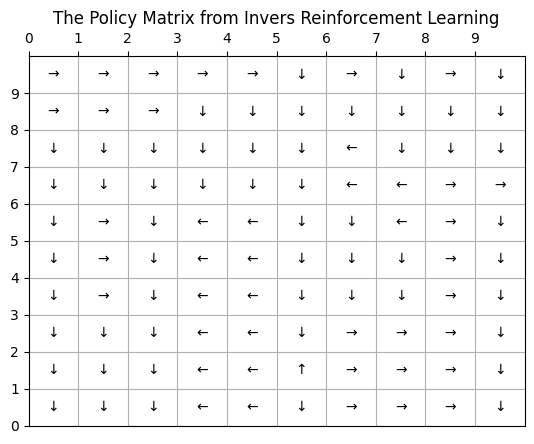

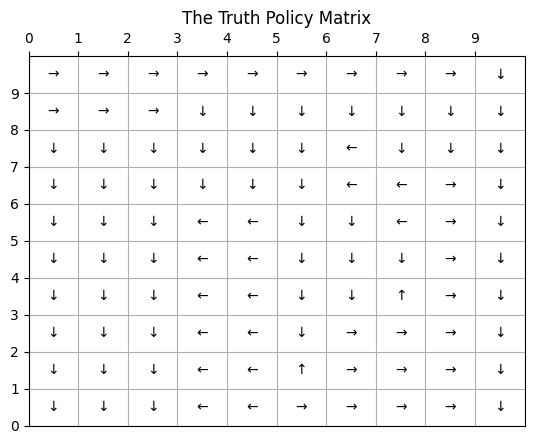

In [25]:
Imshow_Arrow(policy_with_lambda_max_2.reshape(10,10).T, "The Policy Matrix from Invers Reinforcement Learning")

# the original true plot, no need to shown in the report
Imshow_Arrow(policy_truth.reshape(10,10).T, "The Truth Policy Matrix")

Question 24

shown in our report

Question 25

From the figure in question 23, you should observe that the optimal policy
of the agent has two major discrepancies. Please identify and provide the causes for these two discrepancies. One of the discrepancy can be fixed easily by a slight modification to the value iteration algorithm.
Perform this modification and re-run the modified value iteration algorithm to compute the optimal
policy of the agent. Also, recompute the maximum accuracy after this modification. Is there a change in maximum accuracy? The second discrepancy is harder to fix and is a limitation of the simple IRL
algorithm.

In [42]:
# modified value iteration alg to fix first discrepancy in question 23(shown in the RF_2)
# Here we re-defined epsilon from original VI alg to obtain a better convergence
epsilon_mdf = 0.000000001

# re-run the modified VI alg with RF_2
value_2_mdf,policy_2_mdf,total_iteration_number_mdf = value_iteration_function(MDP_wind, RF_2, 0, discount_factor, epsilon_mdf)

number_of_lambda = 500
max_lambda = 5
accuracy_vector = np.zeros(number_of_lambda)
rmax = 1

D, b = LP_formulation(policy_2_mdf,rmax,discount_factor,MDP_wind)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,number_of_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,number_of_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    solution = solvers.lp(matrix(-c),matrix(D),matrix(b))
    option_x = np.array(solution['x'])
    RF_new = np.transpose(np.reshape(option_x[200:],(100,)))
    v,p,t = value_iteration_function(MDP_wind, RF_new, 0, discount_factor, epsilon_mdf)
    accuracy = np.sum(policy_2==p)/MDP_wind.num_of_states
    accuracy_vector[i] = accuracy

流式输出内容被截断，只能显示最后 5000 行内容。
 3: -5.6123e+00 -3.7313e+01  1e+02  2e-01  2e+00  3e-01
 4: -8.0963e+00 -1.5975e+01  3e+01  6e-02  4e-01  8e-02
 5: -8.4399e+00 -1.1908e+01  1e+01  3e-02  2e-01  3e-02
 6: -8.6874e+00 -1.0080e+01  4e+00  1e-02  7e-02  5e-03
 7: -8.9320e+00 -9.3041e+00  1e+00  3e-03  2e-02  1e-03
 8: -8.9755e+00 -9.1594e+00  6e-01  1e-03  9e-03  6e-04
 9: -8.9775e+00 -9.1136e+00  4e-01  1e-03  6e-03  4e-04
10: -8.9924e+00 -9.0407e+00  1e-01  4e-04  2e-03  2e-04
11: -8.9972e+00 -9.0147e+00  5e-02  1e-04  8e-04  6e-05
12: -8.9994e+00 -9.0027e+00  1e-02  3e-05  2e-04  1e-05
13: -8.9996e+00 -9.0000e+00  1e-03  3e-06  2e-05  1e-06
14: -8.9997e+00 -8.9998e+00  2e-04  6e-07  4e-06  2e-07
15: -8.9997e+00 -8.9997e+00  1e-04  3e-07  2e-06  1e-07
16: -8.9997e+00 -8.9997e+00  1e-06  3e-09  2e-08  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0305e+02  2e+03  2e+00  1e+01  1e+00
 1: -4.0290e+00 -1.4746e+02  7e+02  1e+00  7e+00  1e+00

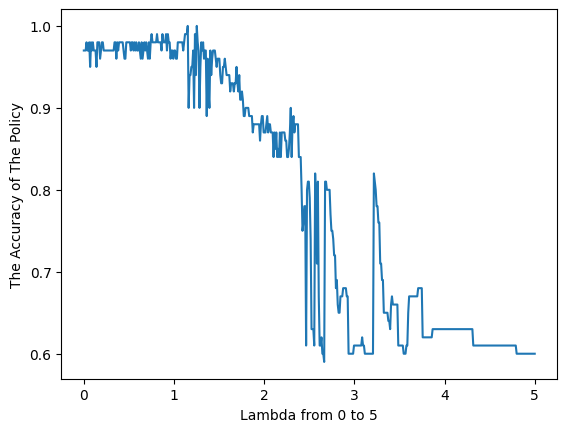

In [43]:
plt.plot(np.linspace(0,max_lambda,number_of_lambda),accuracy_vector)
plt.xlabel('Lambda from 0 to 5')
plt.ylabel('The Accuracy of The Policy')
plt.show()

In [44]:
lamdas = np.linspace(0, 5, 500)
lambda_max_2_mdf = max(lamdas[accuracy_vector == np.max(accuracy_vector)])
print('The Lamda max:', lambda_max_2_mdf)
print('The best accuracy:', max(accuracy_vector))

The Lamda max: 1.25250501002004
The best accuracy: 1.0


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0305e+02  2e+03  2e+00  2e+01  1e+00
 1: -4.9447e+00 -1.3870e+02  6e+02  1e+00  7e+00  1e+00
 2: -6.9748e+00 -4.6150e+01  1e+02  3e-01  2e+00  5e-01
 3: -6.5796e+00 -4.1566e+01  1e+02  3e-01  2e+00  4e-01
 4: -1.0447e+01 -2.1925e+01  4e+01  9e-02  6e-01  1e-01
 5: -1.1583e+01 -1.5138e+01  1e+01  3e-02  2e-01  3e-02
 6: -1.2030e+01 -1.2994e+01  3e+00  7e-03  5e-02  4e-03
 7: -1.2244e+01 -1.2518e+01  9e-01  2e-03  1e-02  1e-03
 8: -1.2292e+01 -1.2374e+01  3e-01  6e-04  4e-03  3e-04
 9: -1.2302e+01 -1.2341e+01  1e-01  3e-04  2e-03  1e-04
10: -1.2307e+01 -1.2321e+01  4e-02  1e-04  7e-04  5e-05
11: -1.2310e+01 -1.2312e+01  5e-03  1e-05  9e-05  6e-06
12: -1.2310e+01 -1.2310e+01  4e-04  9e-07  6e-06  4e-07
13: -1.2310e+01 -1.2310e+01  5e-06  1e-08  9e-08  5e-09
Optimal solution found.
The Calculate Accuracy: 1.000000


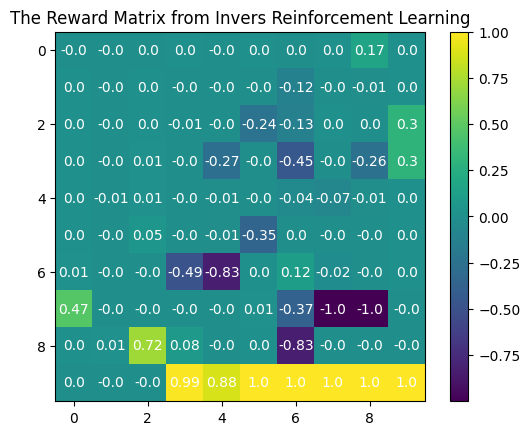

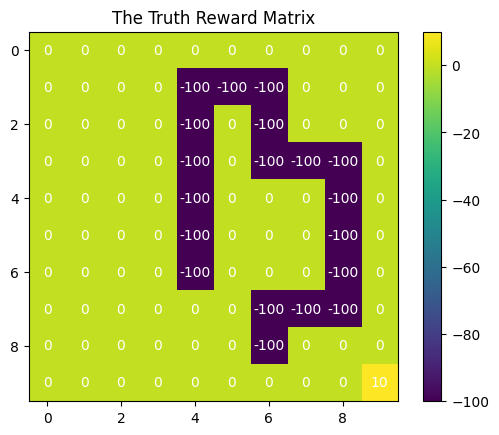

In [45]:
c = np.concatenate([np.ones((N,)), -lambda_max_2_mdf*np.ones((N,)), np.zeros((N,))])
solution = solvers.lp(matrix(-c),matrix(D),matrix(b))
option_x = np.array(solution['x'])
RF_new = np.transpose(np.reshape(option_x[200:],(100,)))

# generate value and policy from the reward function of the lambda max 
value_with_lambda_max_2_mdf,policy_with_lambda_max_2_mdf,total_iteration_number = value_iteration_function(MDP_wind, RF_new, 0, discount_factor, epsilon_mdf)
value_truth_mdf, policy_truth_mdf, total_iteration_number = value_iteration_function(MDP_wind, RF_2, 0, discount_factor, epsilon_mdf)
print("The Calculate Accuracy: %f" % (np.sum(policy_truth_mdf == policy_with_lambda_max_2_mdf)/MDP_wind.num_of_states))

Imshow_HeatMap(RF_new.reshape(10,10).T, "The Reward Matrix from Invers Reinforcement Learning")
Imshow_HeatMap(RF_2.reshape(10,10).T, "The Truth Reward Matrix")

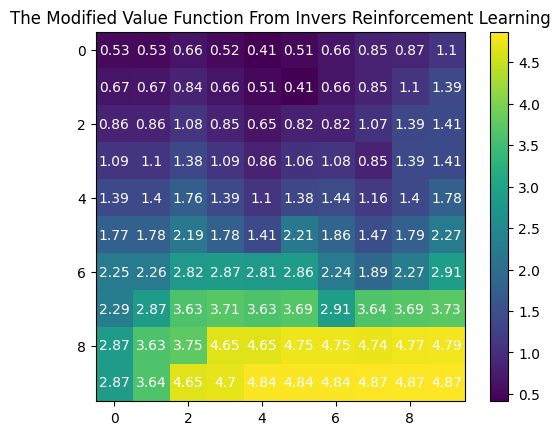

In [46]:
Imshow_HeatMap(value_with_lambda_max_2_mdf.reshape(10,10).T, "The Modified Value Function From Invers Reinforcement Learning")

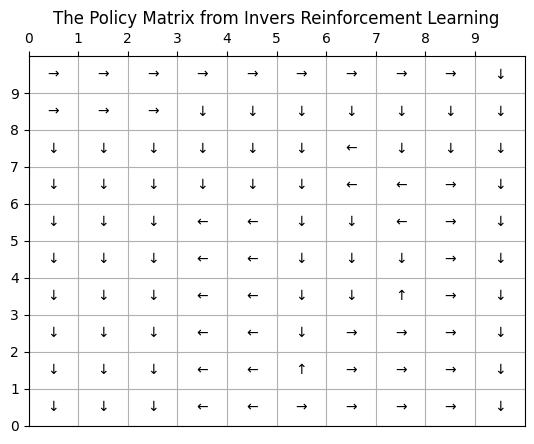

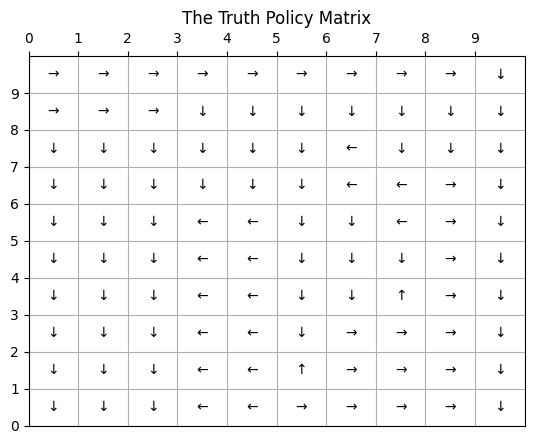

In [47]:
Imshow_Arrow(policy_with_lambda_max_2_mdf.reshape(10,10).T, "The Policy Matrix from Invers Reinforcement Learning")

# the original true plot, no need to shown in the report
Imshow_Arrow(policy_truth_mdf.reshape(10,10).T, "The Truth Policy Matrix")